Author: <font color="blue">Josep Monclús Carrasco</font>

E-mail: <font color="blue">josep.monclus01@estudiant.upf.edu</font>

Date: <font color="blue">18/10/2021</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [2]:
# Input file
#We change the File name CovidLockdownCatalonia.json.gz to data/CovidLockdownCatalonia.json.gz
INPUT_FILENAME = "data/CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [3]:
def jaccard_similarity(l1,l2,to_set=True):
    """
    This function determine the jaccard similarity value between 2 list
    """
    #We transform to set if is necessary
    if to_set:
        s1 = set(l1)
        s2 = set(l2)
    #We compute the union and the intersection
    inters = s1.intersection(s2)
    union = s1.union(s2)
    #This if is only to not run an error (if union is 0 intersection too)
    if len(union) == 0:
        union.add(0)
    return len(inters)/len(union)

In [4]:
#Testing the jaccard_similarity function
# Value 0.0
A = ["a","b","c"]
B = ["d","e","f"]
print("A:",A)
print("B:",B)
print("Jaccard value:",jaccard_similarity(A,B),"\n")
# Value 1/3
A = [1,2,3,7]
B = [1,4,6,7]
print("A:",A)
print("B:",B)
print("Jaccard value:",jaccard_similarity(A,B),"\n")
# Value 1
A = [1,2,3,4]
B = [1,4,2,3]
print("A:",A)
print("B:",B)
print("Jaccard value:",jaccard_similarity(A,B),"\n")
# Value 0.0 with empty arrays
A = []
B = []
print("A:",A)
print("B:",B)
print("Jaccard value:",jaccard_similarity(A,B),"\n")

A: ['a', 'b', 'c']
B: ['d', 'e', 'f']
Jaccard value: 0.0 

A: [1, 2, 3, 7]
B: [1, 4, 6, 7]
Jaccard value: 0.3333333333333333 

A: [1, 2, 3, 4]
B: [1, 4, 2, 3]
Jaccard value: 1.0 

A: []
B: []
Jaccard value: 0.0 



In [5]:
def clean(text):
    """
    This function clean the text by 
    Converting to lowercase
    Removing URLs
    Removing anything that is not a letter or digit
    Romanizes text, replacing "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll"
    """
    text_clean = text.lower()
    #Here we have a array with all the regexpresions that we want to change
    raw_chars = ["ñ","ó|ò","ç","à","é|è","l·l"
                 ,"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?"
                 ,"[^A-Za-z0-9- ]+"]
    #Plus the changes for the regexp
    clean_chars = ["n","o","c","a","e","ll","",""]
    #We apply the changes in the text
    for i,ch in enumerate(raw_chars):
        text_clean = re.sub(ch,clean_chars[i],text_clean)
    
    return text_clean

In [6]:
#We test the function clean
test_text = "RT @Inigo_1987: I am Iñigo Montoya! https://t.co/aaa"
print("Inicial text:",test_text)
print("After cleaning:",clean(test_text))

Inicial text: RT @Inigo_1987: I am Iñigo Montoya! https://t.co/aaa
After cleaning: rt inigo1987 i am inigo montoya 


# 2. Implement an n-gram extractor

In [7]:
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    """
    This function takes a text and size for the ngrams
    And return all the diferent ngrams
    """
    tokens = clean(text).split()
    ngrams = []
    toks = []
    #We eliminate all tokens that don't have the correct length
    for t in tokens:
        if len(t) >= MIN_TOKEN_LENGTH:
            toks.append(t)   
    #We loop the tokens
    for i,token in enumerate(toks):
        #We check that we no overpass the len of the tokens
        if i < len(toks)-(size-1):
            #We create a list with the grams
            gram = [token]
            #For each token we have its n consecutive tokens
            for n in range(1,size):
                gram.append(toks[i+n])
            #We add to ngrams the string with the gram
            ngrams.append(" ".join(gram))
            
    return ngrams

In [8]:
#Testing the ngrams function
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['rt diariara', 'diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [9]:
# Leave this code as-is

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

In [10]:
#We crate x and y
x = range(1,2001,150) #Number of messages to check
y_1 = []
for i in x:
    print("Calculating y(time) for",i,"messages")
    y_1.append(time_brute_force_similarities(messages,i,3)) #Time it takes to check
print("x",x)
print("y",y_1)

Calculating y(time) for 1 messages
Calculating y(time) for 151 messages
Calculating y(time) for 301 messages
Calculating y(time) for 451 messages
Calculating y(time) for 601 messages
Calculating y(time) for 751 messages
Calculating y(time) for 901 messages
Calculating y(time) for 1051 messages
Calculating y(time) for 1201 messages
Calculating y(time) for 1351 messages
Calculating y(time) for 1501 messages
Calculating y(time) for 1651 messages
Calculating y(time) for 1801 messages
Calculating y(time) for 1951 messages
x range(1, 2001, 150)
y [0.0003099699999893346, 1.262121681999929, 4.044841763000022, 8.645247910999956, 15.074330356000019, 22.372796919000052, 33.142331238, 46.15836336999996, 57.49261715099999, 79.80544025999995, 95.25916840399998, 114.63613260000011, 138.25853492300007, 162.7229915559999]


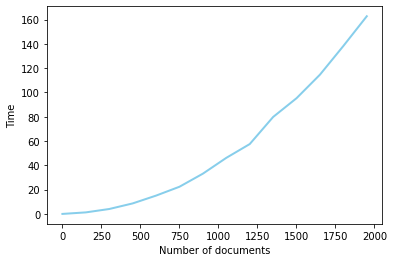

In [35]:
#We plot x and y
#The color is only to decorate
plt.plot(x,y_1,color = "skyblue", linewidth=2, markersize=12)
plt.xlabel("Number of documents")
plt.ylabel("Time")
plt.show()

#### (1)
As we can see in the plot is seems to have a exponential/quadratic relation, so that is telling to us that this algorithm limited asymptomatically with the reason of **O(n^2)**, so this is a lot of time when the number of messages is substantially large.

#### (2)
If we think in a matrix of m columns (documents/messages) and n rows (n_grams) we have a algorithm limited asymptomatically with the reason of **O[m*(n^2)]** this means that with 10000 documents with 70000 number of n_grams in each document our algorithm of brute force has to make 700,000,000 steps. If we aproximate saying that 1 step is equal to 1ms this mean that we need **194.44 hours**, and we are talking only of 10000 documents. It is clear that brute force here is not very scalable, so maybe we have to change the strategy.


# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [16]:
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        #If n_gram didn't apear add it to the dictionaries
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1
        
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 70163 distinct ngrams in the 10000 documents


In [17]:
#Testing the ngram_to_index structure
print(ngram_to_index["tancat escoles fins"])
print(index_to_ngram[ngram_to_index["tancat escoles fins"]])

983
tancat escoles fins


## 2.2 Create table ngrams x documents

In [18]:
# Leave this code as-is

# Create matrix filled with boolean False
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print number of rows and columns
print("Rows: %d (distinct shingles)" % len(M_ngram_doc))
print("Columns: %d (distinct documents)" % len(M_ngram_doc[0]))

Rows: 70163 (distinct shingles)
Columns: 10000 (distinct documents)


In [19]:
ngram_size = NGRAM_SIZE

for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        #we add a true value in the row that is the index of the ngram
        M_ngram_doc[ngram_to_index[ngram]][docid] = True

In [20]:
#Testing the M_ngram_doc matrix by printing rows 9602 and 941

print("Positions of non-zeros in column of docid 9602 of M_ngram_doc")
print("Clean message:")
print(clean(messages[9602]))
print("Non-zeros in corresponding row:")
values = []
for i,boole in enumerate([row[9602] for row in M_ngram_doc]):
    if boole:
        values.append(str(str(i) + " " + index_to_ngram[i]))
print(values,"\n")

print("Positions of non-zeros in column of docid 941 of M_ngram_doc")
print("Clean message:")
print(clean(messages[941]))
print("Non-zeros in corresponding row:")
values = []
for i,boole in enumerate([row[941] for row in M_ngram_doc]):
    if boole:
        values.append(str(str(i) + " " + index_to_ngram[i]))
print(values)

Positions of non-zeros in column of docid 9602 of M_ngram_doc
Clean message:
rt emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio 
Non-zeros in corresponding row:
['684 rt emergenciescat que', '956 si us plau', '1275 emergenciescat que puc', '1276 que puc fer', '1277 puc fer que', '1278 fer que no', '2683 14 de marc', '40898 que no faqs', '40899 no faqs del', '40900 faqs del coronavirus', '40901 del coronavirus 14', '40902 coronavirus 14 de', '40903 de marc si', '40904 marc si us', '40905 us plau demanem', '40906 plau demanem difusio'] 

Positions of non-zeros in column of docid 941 of M_ngram_doc
Clean message:
rt hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general
Non-zeros in corresponding row:
['1541 usem de forma', '1542 de forma responsable', '1543 forma responsable els', '1544 responsable els recursos', '1545 els recursos sanitaris061', '1546 recursos sanitaris061

# 3. Implement a permutation generator

In [21]:
#We load the random library
import random

def random_permutation(k):
    """
    This function generate a random permutation of k elements
    """
    #We create the list
    rand_per = list(range(k))
    #We shuffle the list
    random.shuffle(rand_per)
    return rand_per

In [22]:
# Leave this code as-is

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["a", "b", "c", "d", "e"]
original_list_2 = ["alpha", "beta", "gamma", "delta", "epsilon"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['d', 'a', 'b', 'e', 'c']
['delta', 'alpha', 'beta', 'epsilon', 'gamma']

Test another permutation
['b', 'a', 'd', 'e', 'c']
['beta', 'alpha', 'delta', 'epsilon', 'gamma']


# 4. Compute the signature of each document

In [23]:
# Leave this code as-is

NUM_PERMUTATIONS = 4

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 45480, 10982, 38913, ...
Permutation 1: 47701, 5714, 35698, ...
Permutation 2: 50583, 53229, 57945, ...
Permutation 3: 24221, 15695, 21637, ...


In [24]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        #We take the the first ngram (the "minimum" one) 
        min_has = find_first_one(docid,permutation)
        #We put in the row that correspond to the permutation and 
        #The corresponding doc id the min has value
        M_signature_doc[permutation_num][docid] = min_has
        
        

Creating signatures for permutation 1/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [25]:
# Leave this code as-is

def extract_ngrams(docid):
    #Hay que cambiar i por docid porque esta printeando la cosa equivocada
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 84
j = 6586

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #84
Message       : RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Clean message : rt emergenciescat  es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
Ngrams        : [274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294]
Signature     : [279.0, 291.0, 279.0, 280.0]

Document #6586
Message       : RT @emergenciescat: ⚠️ El @govern demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS innecessaris. Tot el que sigui…
Clean message : rt emergenciescat  el govern demana a la ciutadania limitar al maxim i si es pot evitar desplacaments innecessaris tot el que sigui
Ngrams        : [277, 278, 279, 280, 281, 282, 283, 284, 285, 292, 293, 329, 3009, 4286, 4287, 4288, 4289, 4290]
Signature     : [279.0, 279.0, 279.0, 280.0]


# 5. Compare all pairs of signatures

In [26]:
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed
                j_s = jaccard_similarity(signature1,signature2)
                if j_s == 1:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = j_s
                if j_s > 0.2 and j_s < 1:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = j_s

        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        if (count_sig_full_matches + count_sig_partial_matches) > 50:
            print("The document",docid1,":")
            print(messages[docid1])
            print("Has",count_sig_full_matches,"full matches with documents")
            print("And has",count_sig_partial_matches,"partial matches with documents","\n")

0/10000 documents scanned
The document 13 :
Las matemáticas ayudan mucho.
Por favor, hagámosles  caso.

Quin és el pitjor escenari de la propagació del coronavirus a Catalunya i a Espanya, segons els models matemàtics? https://t.co/rdlIY1sroj
Has 3 full matches with documents
And has 63 partial matches with documents 

The document 16 :
RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Has 71 full matches with documents
And has 20 partial matches with documents 

The document 19 :
RT @emergenciescat: El comitè tècnic del Pla #PROCICAT  per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…
Has 0 full matches with documents
And has 93 partial matches with documents 

The document 53 :
RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzada pel #Coronavirus que afecta i afectar…
Has 57 full matches with documents
And has 0 

As we can see for example with the doc 16 it has a lot of complete matches and not partial, because it seems to be a informative tweet of the state to explain the new lockdown rules, so maybe a lot of people retweeted this without changing only to inform their friends/family

The document 77 it has a lot of partial marches and fewer complete, but for the content of the tweet seems to be a Questions and Answers to the state so maybe the people asked with the same structure or maybe there is a list of diferent tweets with the rules about what you can and you can not do.

<font size="+2" color="blue">Additional results: running time comparison</font>

We are going to compare 4 different signature sizes to see the differences on time, and for this we have to create a function that takes the signature size and the number of documents and do the computation but we take only the time.

In [27]:
def time_signature_shinglin(n_docs, ngram_size, sign_size):
    """
    This function compute the time to calculate the similarity using shinglin
    """
    start = timer()
    
    permutations = []

    # Create the permutations
    for i in range(sign_size):
        permutation = random_permutation(num_distinct_ngrams)
        permutations.append(random_permutation(num_distinct_ngrams))
             
    M_signature_doc = np.full((sign_size, n_docs), np.nan)
        
    # Create permutations
    for permutation_num in range(sign_size):
        #print("Creating signatures for permutation %d/%d" % (permutation_num+1, sign_size))
        permutation = permutations[permutation_num]
        for docid in range(n_docs):
            #if docid % 1000 == 0:
                #print("- Scanning document %d of %d" % (docid, n_docs))
            #We take the the first ngram (the "minimum" one) 
            min_has = find_first_one(docid,permutation)
            #We put in the row that correspond to the permutation and 
            #The corresponding doc id the min has value
            M_signature_doc[permutation_num][docid] = min_has
        
    is_possible_duplicate = {}

    # Iterate through all documents
    for docid1 in range(n_docs):

         # Do not examine again a document that is a possible duplicate
        if docid not in is_possible_duplicate:

            # Counters for full and partial signature matches
            count_sig_full_matches = 0
            count_sig_partial_matches = 0

            # Extract the signature of the doc1
            signature1 = extract_signature(docid1)
            #if docid1 % 500 == 0:
                #print("%d/%d documents scanned" % (docid1, len(messages)))

            # Iterate through documents with docid larger than doc1
            for docid2 in range(docid1+1, n_docs):

                # If this has not already been marked as duplicate of another document
                if docid2 not in is_possible_duplicate:

                    # Extract signature of doc2
                    signature2 = extract_signature(docid2)

                    # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                    # - Include docid2 in is_possible_duplicate if needed
                    j_s = jaccard_similarity(signature1,signature2)
                    if j_s == 1:
                        count_sig_full_matches += 1
                        is_possible_duplicate[docid2] = j_s
                    if j_s > 0.2 and j_s < 1:
                        count_sig_partial_matches += 1
                        is_possible_duplicate[docid2] = j_s
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        if (count_sig_full_matches + count_sig_partial_matches) > 100:
            print("The document",docid1,":")
            print(messages[docid1])
            print("Has",count_sig_full_matches,"full matches with documents")
            print("And has",count_sig_partial_matches,"partial matches with documents","\n")
    
    
    end = timer()
    return (end - start)

In [28]:
#We create x and y
#We try with signature size of 2
x = range(1,2001,150) #Number of messages to check
y = []
for i in x:
    print("Calculating y(time) for",i,"messages")
    y.append(time_signature_shinglin(i,3,2)) #Time it takes to check
print("x",x)
print("y",y)

Calculating y(time) for 1 messages
Calculating y(time) for 151 messages
Calculating y(time) for 301 messages
Calculating y(time) for 451 messages
Calculating y(time) for 601 messages
Calculating y(time) for 751 messages
Calculating y(time) for 901 messages
Calculating y(time) for 1051 messages
Calculating y(time) for 1201 messages
Calculating y(time) for 1351 messages
Calculating y(time) for 1501 messages
Calculating y(time) for 1651 messages
Calculating y(time) for 1801 messages
Calculating y(time) for 1951 messages
x range(1, 2001, 150)
y [0.2999991679998857, 2.187665268999808, 4.138944653999715, 6.527139383999838, 8.473677432000386, 11.658511201999772, 14.32532877299991, 14.970239845999913, 17.78700793600001, 21.427150571999846, 21.086315668000225, 24.833022659000108, 23.996303139000247, 23.48562280599981]


In [29]:
#We try with signature size of 4
y1 = []
for i in x:
    print("Calculating y(time) for",i,"messages")
    y1.append(time_signature_shinglin(i,3,4)) #Time it takes to check
print("x",x)
print("y1",y1)

Calculating y(time) for 1 messages
Calculating y(time) for 151 messages
Calculating y(time) for 301 messages
Calculating y(time) for 451 messages
Calculating y(time) for 601 messages
Calculating y(time) for 751 messages
Calculating y(time) for 901 messages
Calculating y(time) for 1051 messages
Calculating y(time) for 1201 messages
Calculating y(time) for 1351 messages
Calculating y(time) for 1501 messages
Calculating y(time) for 1651 messages
Calculating y(time) for 1801 messages
Calculating y(time) for 1951 messages
x range(1, 2001, 150)
y1 [0.40380794000020614, 3.9610869409998486, 7.523433126999862, 11.939966576999723, 18.713059266999608, 21.17242136599998, 26.889571717000308, 30.545218853999813, 31.45398503599972, 36.89132997200022, 40.446576585, 44.70473072100003, 45.19515996100017, 53.08624477600006]


In [30]:
#We try with signature size of 6
y2 = []
for i in x:
    print("Calculating y(time) for",i,"messages")
    y2.append(time_signature_shinglin(i,3,6)) #Time it takes to check
print("x",x)
print("y1",y1)

Calculating y(time) for 1 messages
Calculating y(time) for 151 messages
Calculating y(time) for 301 messages
Calculating y(time) for 451 messages
Calculating y(time) for 601 messages
Calculating y(time) for 751 messages
Calculating y(time) for 901 messages
Calculating y(time) for 1051 messages
Calculating y(time) for 1201 messages
Calculating y(time) for 1351 messages
Calculating y(time) for 1501 messages
Calculating y(time) for 1651 messages
Calculating y(time) for 1801 messages
Calculating y(time) for 1951 messages
x range(1, 2001, 150)
y1 [0.40380794000020614, 3.9610869409998486, 7.523433126999862, 11.939966576999723, 18.713059266999608, 21.17242136599998, 26.889571717000308, 30.545218853999813, 31.45398503599972, 36.89132997200022, 40.446576585, 44.70473072100003, 45.19515996100017, 53.08624477600006]


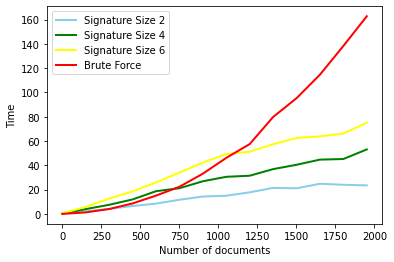

In [34]:
#We plot x and y
#The color is to difference the signature size
plt.plot(x,y,color = "skyblue", linewidth=2, markersize=12,label="Signature Size 2")
plt.plot(x,y1,color = "green", linewidth=2, markersize=12,label="Signature Size 4")
plt.plot(x,y2,color = "yellow", linewidth=2, markersize=12,label="Signature Size 6")
plt.plot(x,y_1,color = "red", linewidth=2, markersize=12,label="Brute Force")
plt.legend()
plt.xlabel("Number of documents")
plt.ylabel("Time")
plt.show()

As we can see there is a big difference in terms of time between signature algorithm and brute force

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>